In [3]:
#Loading Packages
from matplotlib import ticker
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joypy
import re
import networkx as nx

In [2]:
pip install textblob


     ---------------------------------------- 0.0/636.8 kB ? eta -:--:--
      --------------------------------------- 10.2/636.8 kB ? eta -:--:--
      --------------------------------------- 10.2/636.8 kB ? eta -:--:--
     - ----------------------------------- 30.7/636.8 kB 262.6 kB/s eta 0:00:03
     --- --------------------------------- 61.4/636.8 kB 363.1 kB/s eta 0:00:02
     ------------- ------------------------ 225.3/636.8 kB 1.1 MB/s eta 0:00:01
     ----------------------------------- -- 593.9/636.8 kB 2.3 MB/s eta 0:00:01
     -------------------------------------- 636.8/636.8 kB 2.4 MB/s eta 0:00:00


In [4]:
#Loading the Dataset
df = pd.read_excel('Cleaned_DS.xlsx')

# Sentiment Analysis

In [5]:
#Ensure all reviews are strings and preprocess
df['cleaned_reviews'] = df['reviewFullText'].astype(str).str.lower().str.replace('[^a-z]', ' ', regex=True)

#Calculating sentiment
df['sentiment'] = df['cleaned_reviews'].apply(lambda x: TextBlob(x).sentiment.polarity if x else 0)

print(df[['reviewFullText', 'sentiment']].head())

                                      reviewFullText  sentiment
0  Absolutely breathtaking use of light, an amazi...      0.492
1  A really interesting and beautiful place to vi...      0.490
2  Beautiful place and must visit place in barcel...      0.550
3  A MUST when visiting Barcelkona.  It is consta...      0.000
4  I visited about 20 years ago and there has bee...      0.450


In [6]:
#Usually when a review has a "MUST" it's a positive comment, so it's doesn't seem correct that the result is 0 so we changed it to 0.5 for all reviews containing the word must
def adjust_sentiment(row):
    review_text = str(row['reviewFullText'])  # Convert to string to avoid AttributeError
    if 'must' in review_text.lower():
        return max(row['sentiment'], 0.5)  # Ensures a minimum positive sentiment
    return row['sentiment']

df['adjusted_sentiment'] = df.apply(adjust_sentiment, axis=1)


In [7]:
#Display a few rows where "must" is in the review text
must_reviews = df[df['reviewFullText'].str.contains("must", case=False, na=False)]

#Show original and adjusted sentiment scores for these rows
comparison = must_reviews[['reviewFullText', 'sentiment', 'adjusted_sentiment']]

print(comparison.head())


                                       reviewFullText  sentiment  \
2   Beautiful place and must visit place in barcel...   0.550000   
3   A MUST when visiting Barcelkona.  It is consta...   0.000000   
11  The Sagrada Familia is the most visited attrac...   0.157143   
12  A must visit!  The interior looks nearly compl...   0.427778   
16  Magnificent building with a lot of details. A ...   0.483333   

    adjusted_sentiment  
2                 0.55  
3                 0.50  
11                0.50  
12                0.50  
16                0.50  


In [8]:
#Analyzing Average Sentiment By Trip Type
average_sentiment_by_trip_type = df.groupby('tripType')['sentiment'].mean()
print(average_sentiment_by_trip_type)

tripType
Business    0.310739
Couples     0.298772
Family      0.294845
Friends     0.307309
Solo        0.300918
Name: sentiment, dtype: float64


In [9]:
#Getting polarity and subjectivity scores
df['analysis'] = df['reviewFullText'].apply(lambda x: TextBlob(str(x)).sentiment)

#Extracting polarity and subjectivity scores from the analysis column
df['polarity'] = df['analysis'].apply(lambda x: x.polarity)
df['subjectivity'] = df['analysis'].apply(lambda x: x.subjectivity)

#Creating Column with Sentiment Analysis
df['sentiment'] = df['polarity'].apply(lambda x: "Positive" if x > 0 else ("Negative" if x < 0 else "Neutral"))

print(df[['reviewFullText', 'polarity', 'subjectivity', 'sentiment']].head())

                                      reviewFullText  polarity  subjectivity  \
0  Absolutely breathtaking use of light, an amazi...     0.492      0.648000   
1  A really interesting and beautiful place to vi...     0.490      0.600000   
2  Beautiful place and must visit place in barcel...     0.550      0.666667   
3  A MUST when visiting Barcelkona.  It is consta...     0.000      0.166667   
4  I visited about 20 years ago and there has bee...     0.450      0.550000   

  sentiment  
0  Positive  
1  Positive  
2  Positive  
3   Neutral  
4  Positive  


In [10]:
# Defining the bins and labels for subjectivity degrees
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

# Create a new column 'subjectivity_degree' based on the bins
df['subjectivity_degree'] = pd.cut(df['subjectivity'], bins=bins, labels=labels, include_lowest=True)

# Display the DataFrame with with sentiment analysis results
print(df[['reviewFullText', 'polarity', 'subjectivity', 'sentiment', 'subjectivity_degree']].head())

                                      reviewFullText  polarity  subjectivity  \
0  Absolutely breathtaking use of light, an amazi...     0.492      0.648000   
1  A really interesting and beautiful place to vi...     0.490      0.600000   
2  Beautiful place and must visit place in barcel...     0.550      0.666667   
3  A MUST when visiting Barcelkona.  It is consta...     0.000      0.166667   
4  I visited about 20 years ago and there has bee...     0.450      0.550000   

  sentiment subjectivity_degree  
0  Positive                High  
1  Positive            Moderate  
2  Positive                High  
3   Neutral            Very Low  
4  Positive            Moderate  


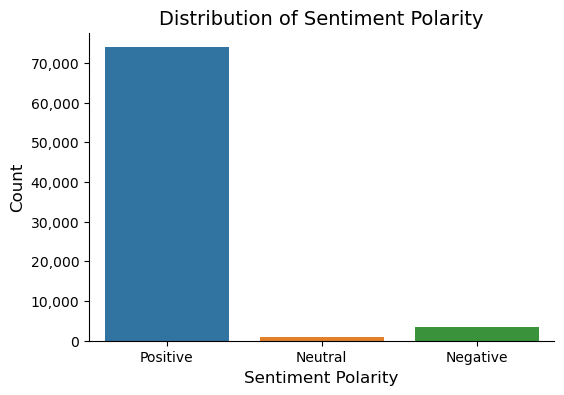

In [11]:
#Creating a Plot To Compare Local Tourism vs Foreign Tourism
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(data=df, x='sentiment', ax=ax)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
sns.despine()
ax.set_title("Distribution of Sentiment Polarity", fontsize=14)  
ax.set_xlabel("Sentiment Polarity", fontsize=12)  
ax.set_ylabel("Count", fontsize=12)
plt.show()

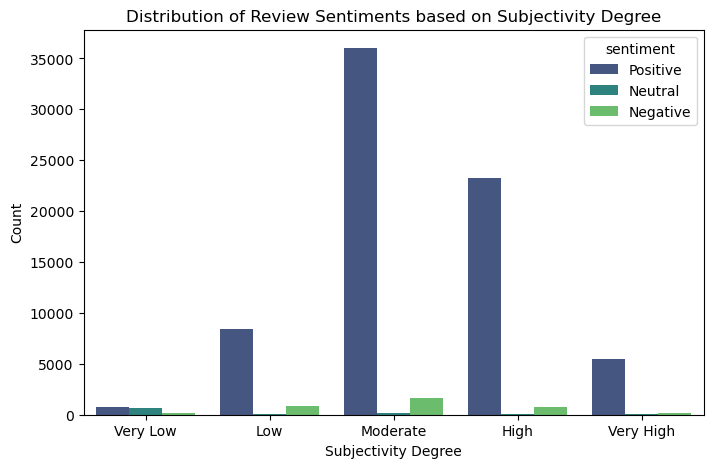

In [12]:
#Bar Plotting to see distribution of Review Sentiments sentiment and subjectivity degree
plt.figure(figsize=(8, 5))
sns.countplot(x='subjectivity_degree', hue='sentiment', data=df, order=labels, palette='viridis')
plt.title('Distribution of Review Sentiments based on Subjectivity Degree')
plt.xlabel('Subjectivity Degree')
plt.ylabel('Count')
plt.show()

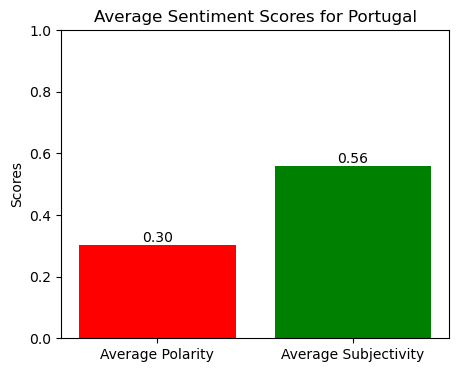

In [13]:
#Getting to know Portugal score in sentiment polarity subjectivity
#Filter rows for 'Country' variable being 'Portugal'
portugal_reviews = df[df['Country'] == 'Portugal']

# Calculate average sentiment polarity and subjectivity for Portugal
average_polarity = portugal_reviews['polarity'].mean()
average_subjectivity = portugal_reviews['subjectivity'].mean()

#Creating a Plot to visulize the data
scores = [average_polarity, average_subjectivity]
score_labels = ['Average Polarity', 'Average Subjectivity']
plt.figure(figsize=(5, 4))
plt.bar(score_labels, scores, color=['red', 'green'])
plt.title('Average Sentiment Scores for Portugal')
plt.ylabel('Scores')
plt.ylim(0, 1) 

#Displaying exact values
for i in range(len(scores)):
    plt.text(i, scores[i] + 0.01, f"{scores[i]:.2f}", ha='center')

plt.show()

The average sentiment polarity for Portugal is approximately 0.30, which is a positive value. The average subjectivity for Portugal is approximately 0.56. 

In summary, based on the sentiment analysis results:

* Reviews related to Portugal, on average, tend to have a positive sentiment.
* The content of these reviews is moderately subjective, indicating a mix of objective and subjective expressions.

In [14]:
# Assessing if our Sentiment Analysis meets the 85% accuracy criteria
#Convert non-string values in 'reviewFullText' to strings
df['reviewFullText'] = df['reviewFullText'].astype(str)

#Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df['reviewFullText'], df['sentiment'], test_size=0.2, random_state=42)

#Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

#Train a Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(train_vectors, train_labels)

#Predict sentiments on the test set
predictions = classifier.predict(test_vectors)

#Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
conf_matrix = confusion_matrix(test_labels, predictions)
classification_rep = classification_report(test_labels, predictions, zero_division=1)

# Print the evaluation results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Accuracy: 94.04%

Confusion Matrix:
[[    0     0   716]
 [    0     0   218]
 [    0     0 14748]]

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.00      0.00       716
     Neutral       1.00      0.00      0.00       218
    Positive       0.94      1.00      0.97     14748

    accuracy                           0.94     15682
   macro avg       0.98      0.33      0.32     15682
weighted avg       0.94      0.94      0.91     15682



Based on this result, we can trust that the sentiment analysis is correct

# Time Series Analysis

Objective of Time Series Analysis:
-Analyze Trends Over Time: Understand how the number of reviews and average ratings for locations have varied over time.
-Pre and Post Pandemic Comparison: Specifically, compare these trends before and after the onset of the COVID-19 pandemic.

In [15]:
# Convert the review dates to datetime objects if not already done
df['reviewVisited'] = pd.to_datetime(df['reviewVisited'])

# Define the start date of the pandemic
pandemic_start_date = '2020-03-01'

# Split the data into pre-pandemic and post-pandemic
pre_pandemic = df[df['reviewVisited'] < pandemic_start_date]
post_pandemic = df[df['reviewVisited'] >= pandemic_start_date]

# Aggregate the data by month (or another suitable period)
# For review counts
monthly_review_counts_pre = pre_pandemic.resample('M', on='reviewVisited').size()
monthly_review_counts_post = post_pandemic.resample('M', on='reviewVisited').size()

# For average ratings
monthly_avg_rating_pre = pre_pandemic.resample('M', on='reviewVisited')['reviewRating'].mean()
monthly_avg_rating_post = post_pandemic.resample('M', on='reviewVisited')['reviewRating'].mean()


Answer to Business Question: How did the pandemic affect visitor patterns in terms of frequency?

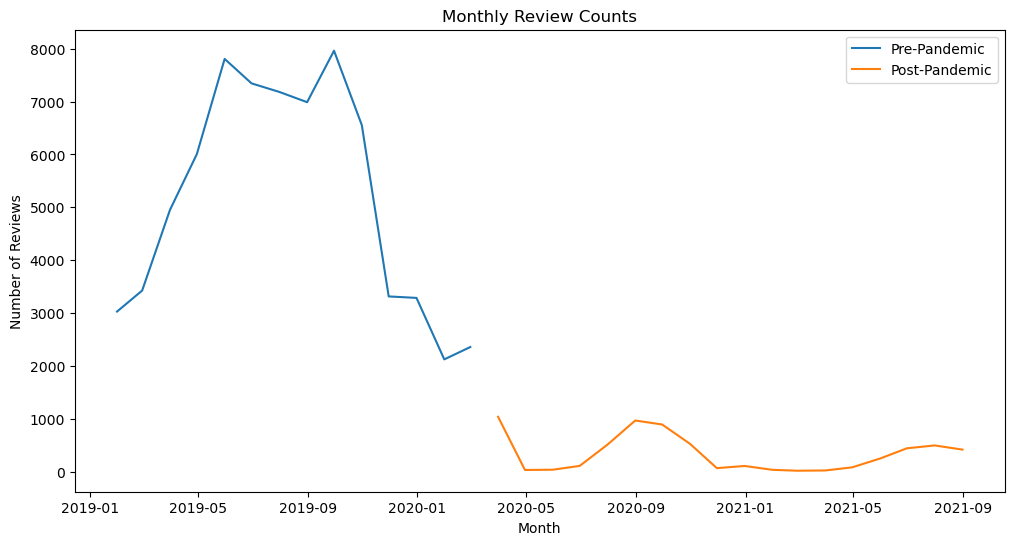

In [16]:
# Plotting monthly review counts
plt.figure(figsize=(12, 6))
plt.plot(monthly_review_counts_pre, label='Pre-Pandemic')
plt.plot(monthly_review_counts_post, label='Post-Pandemic')
plt.title('Monthly Review Counts')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()


Answer to Business Question: How did the pandemic affect visitor patterns in terms of ratings of reviews?

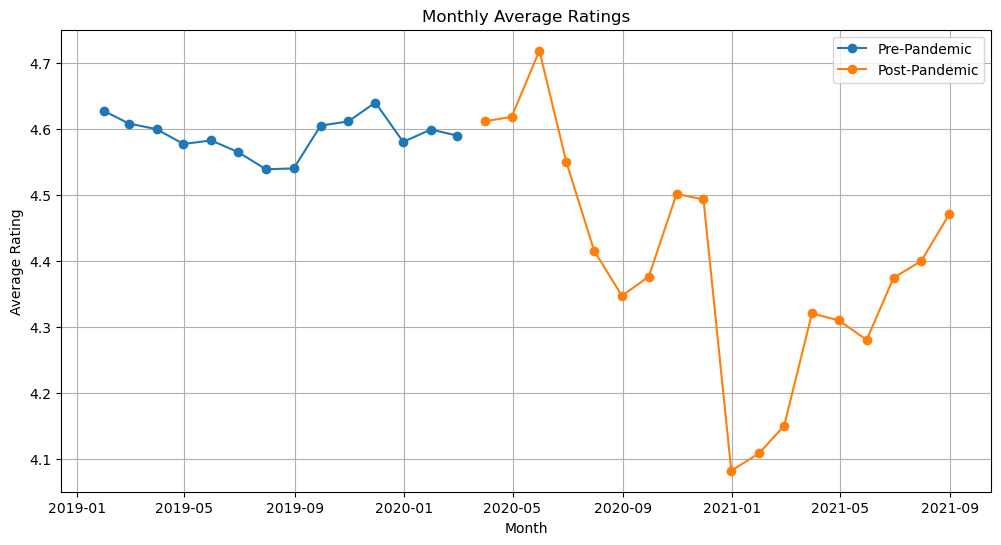

In [17]:
# Plotting the average ratings
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_rating_pre.index, monthly_avg_rating_pre, label='Pre-Pandemic', marker='o')
plt.plot(monthly_avg_rating_post.index, monthly_avg_rating_post, label='Post-Pandemic', marker='o')
plt.title('Monthly Average Ratings')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.legend()
plt.grid(True)
plt.show()

# Further Comparisons

Answering Business Question: What are the common characteristics of tourists to Portuguese attractions compared to competitors?

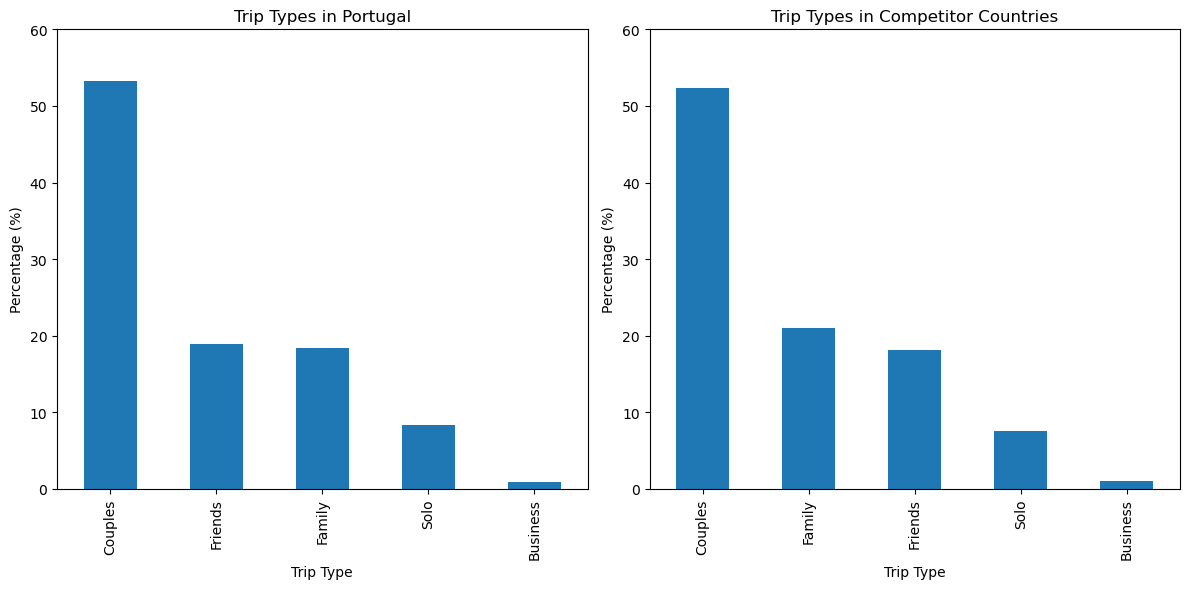

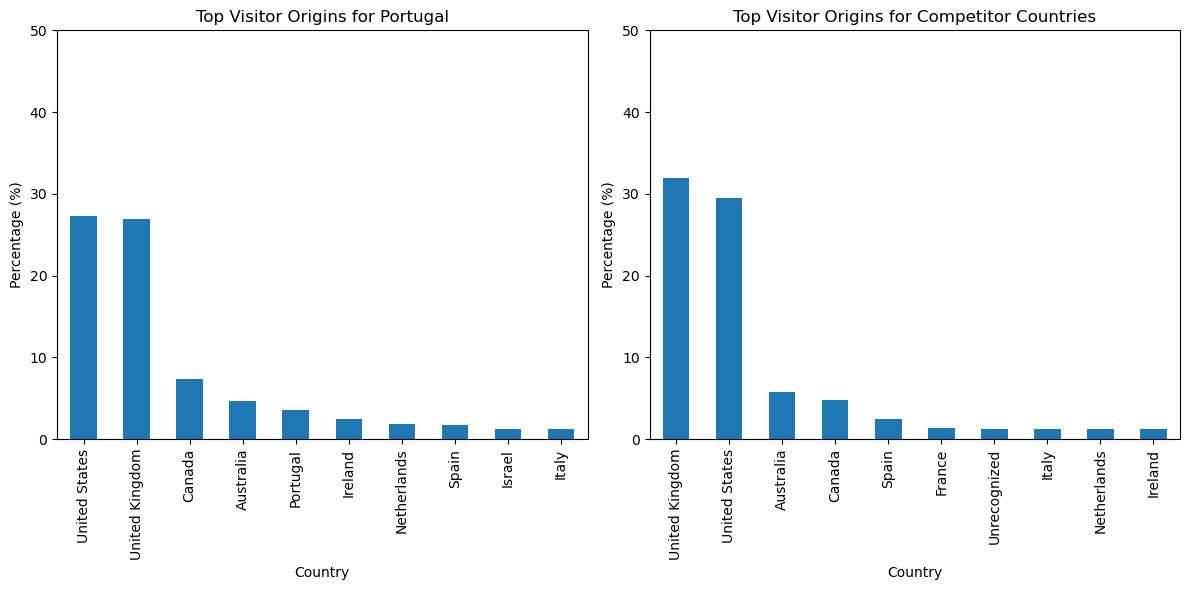

In [18]:
portugal_data = df[df['Country'] == 'Portugal'] #Dataframe subset for Portuguese Atractions Only
competitors_data = df[df['Country'].isin(['Spain', 'Hungary', 'Czech Republic', 'France', 'Italy'])]  #Dataframe subset for all other country Atractions

#Analyze Trip Type 
trip_type_portugal = portugal_data['tripType'].value_counts(normalize=True) * 100 #Multiplying by 100 to give the results in percentage.
trip_type_competitors = competitors_data['tripType'].value_counts(normalize=True) * 100 #Multiplying by 100 to give the results in percentage.

#Analyze Visitor Origins
visitor_origin_portugal = portugal_data['userLocation'].value_counts(normalize=True).head(10) * 100  # top 10 origins
visitor_origin_competitors = competitors_data['userLocation'].value_counts(normalize=True).head(10) * 100

#In order to have the graphs with the same scale for Portugal VS Other Countries we need to set the max scale value
max_percentage_trip_type = 60
max_percentage_visitor_origin = 50

#Creating PLOT for Trip Types
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
trip_type_portugal.plot(kind='bar')
plt.title('Trip Types in Portugal')
plt.ylabel('Percentage (%)')
plt.xlabel('Trip Type')
plt.ylim(0, max_percentage_trip_type)

plt.subplot(1, 2, 2)
trip_type_competitors.plot(kind='bar')
plt.title('Trip Types in Competitor Countries')
plt.ylabel('Percentage (%)')
plt.xlabel('Trip Type')
plt.ylim(0, max_percentage_trip_type)

plt.tight_layout()
plt.show()

#Creating PLOT for Visitor Origins
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
visitor_origin_portugal.plot(kind='bar')
plt.title('Top Visitor Origins for Portugal')
plt.ylabel('Percentage (%)')
plt.xlabel('Country')
plt.ylim(0, max_percentage_visitor_origin)

plt.subplot(1, 2, 2)
visitor_origin_competitors.plot(kind='bar')
plt.title('Top Visitor Origins for Competitor Countries')
plt.ylabel('Percentage (%)')
plt.xlabel('Country')
plt.ylim(0, max_percentage_visitor_origin)

plt.tight_layout()
plt.show()


From these Graphs we can understand that the trip type and and the Top Visitors from portugal are similar to the rest of the countries.
Since this is the case, our Marketing team can take look into strategies from other Tourism companies that have proven sucessful and implement them.
* Competitors: Spain, Hungary, Czech Republic, France, Italy.

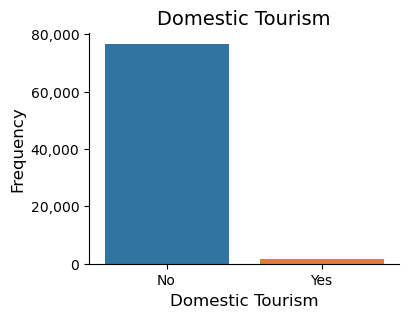

In [19]:
#Creating a Column To check for Local Tourism

df['Domestic_Tourism'] = df.apply(lambda row: 'Yes' if row['Country'] == row['userLocation'] else 'No', axis=1)

#Creating a Plot To Compare Local Tourism vs Foreign Tourism
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(data=df, x='Domestic_Tourism', ax=ax)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
sns.despine()
ax.set_title("Domestic Tourism", fontsize=14)  
ax.set_xlabel("Domestic Tourism", fontsize=12)  
ax.set_ylabel("Frequency", fontsize=12)
plt.show()

The information we can extract from this graph is that our Marketing team should focus their efforts in targeting people from other countries since the correspond to the huge majority. 